In [1]:
import pandas as pd

# Cargar el archivo CSV en un DataFrame
df_data = pd.read_csv('complaints.csv')

# Mostrar las primeras filas del DataFrame para verificar el contenido
print(df_data.head())


C:\Users\gigim\AppData\Local\Temp\ipykernel_14780\3434250453.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv('complaints.csv')


  Date received                                            Product  \
0    2024-10-17  Credit reporting or other personal consumer re...   
1    2024-10-17  Credit reporting or other personal consumer re...   
2    2024-10-17  Credit reporting or other personal consumer re...   
3    2024-10-17  Credit reporting or other personal consumer re...   
4    2024-10-17  Credit reporting or other personal consumer re...   

        Sub-product                                              Issue  \
0  Credit reporting               Incorrect information on your report   
1  Credit reporting               Incorrect information on your report   
2  Credit reporting               Incorrect information on your report   
3  Credit reporting               Incorrect information on your report   
4  Credit reporting  Problem with a company's investigation into an...   

                              Sub-issue Consumer complaint narrative  \
0         Account information incorrect                       

In [2]:
df_filtered = df_data.dropna(subset=['Consumer complaint narrative'])
# Mostrar las filas con texto en 'Consumer complaint narrative'
textual_data = df_data[df_data['Consumer complaint narrative'].notna()]
df_filtered_1 = df_filtered.sample(n=5000, random_state=42)

# Mostrar las primeras filas de esa columna con texto
print("\nAlgunas filas de 'Consumer complaint narrative' con texto:")
print(textual_data['Consumer complaint narrative'].head())

# Contar el total de filas con texto y el total de filas del DataFrame
num_texts = df_filtered_1.shape[0]
total_rows = df_data.shape[0]

# Imprimir los resultados
print(f"\nNúmero de filas con texto en 'Consumer complaint narrative': {num_texts}")
print(f"Total de filas en el DataFrame: {total_rows}")



Algunas filas de 'Consumer complaint narrative' con texto:
406    This agency is violating your consumer rights ...
483    I made a purchase, order # XXXX, from XXXX XXX...
544    You are in violation of 15 USC 1681s- ( 2 ) ( ...
565    Subject : TransUnion 's Violation of the Fair ...
582    I am writing to address the ongoing inaccuraci...
Name: Consumer complaint narrative, dtype: object

Número de filas con texto en 'Consumer complaint narrative': 5000
Total de filas en el DataFrame: 6486747


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk
import nltk
# Descargar recursos necesarios para nltk 
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Función para preprocesar el texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Eliminar stopwords en inglés 
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lematizar 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Calcular el número de instancias por clase
class_counts = df_filtered_1['Product'].value_counts()

# Definir un umbral mínimo de instancias por clase 
min_samples = 200

# Filtrar las filas cuyo 'Product' tenga al menos el número mínimo de instancias
df_filtered_1 = df_filtered_1[df_filtered_1['Product'].isin(class_counts[class_counts >= min_samples].index)]


# Aplicar el preprocesamiento a la columna 'Consumer complaint narrative'
df_filtered_1['processed_text'] = df_filtered_1['Consumer complaint narrative'].apply(preprocess_text)

# Mostrar algunas filas del texto 
print(df_filtered_1[['Consumer complaint narrative', 'processed_text']].head())



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gigim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                              Consumer complaint narrative  \
2843302  I filed a dispute for incorrect information on...   
816632   In the quiet humdrum of everyday life, a sudde...   
572851   In accordance with the Fair Credit Reporting A...   
3388965  In accordance with the Fair Credit Reporting a...   
3110399  I have tried on numerous occasions to get Lexi...   

                                            processed_text  
2843302  filed dispute incorrect information credit rep...  
816632   quiet humdrum everyday life sudden jolt shatte...  
572851   accordance fair credit reporting act account x...  
3388965  accordance fair credit reporting act list acco...  
3110399  tried numerous occasion get lexis nexis remove...  


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # Ejemplo con bigramas


# Ajustar y transformar los textos procesados
X = df_filtered_1['processed_text']
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Mostrar el tamaño de la matriz TF-IDF
print(f"Tamaño del vector TF-IDF: {X_tfidf.shape}")


Tamaño del vector TF-IDF: (4386, 10000)


In [5]:
from sklearn.model_selection import train_test_split

# Extraer las características y etiquetas después de filtrar
X = df_filtered_1['processed_text']
y = df_filtered_1['Product']

# Volver a vectorizar con TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")



Tamaño del conjunto de entrenamiento: (3508, 10000)
Tamaño del conjunto de prueba: (878, 10000)


In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Inicializar el modelo Naive Bayes
nb_model = MultinomialNB()

# Entrenar el modelo
nb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = nb_model.predict(X_test)

# Evaluar el rendimiento del modelo
print(classification_report(y_test, y_pred))


                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       1.00      0.17      0.29        41
                                                 Credit card or prepaid card       1.00      0.02      0.04        54
                         Credit reporting or other personal consumer reports       0.74      0.39      0.51       249
Credit reporting, credit repair services, or other personal consumer reports       0.48      0.92      0.63       347
                                                             Debt collection       0.79      0.32      0.45       120
                                                                    Mortgage       0.96      0.33      0.49        67

                                                                    accuracy                           0.55       878
                                                      

In [7]:
import pandas as pd

# 1. Obtener los totales por categoría en el conjunto completo
total_por_categoria = df_filtered_1['Product'].value_counts()

# 2. Obtener la cantidad de datos por categoría en el conjunto de entrenamiento
entrenamiento_por_categoria = y_train.value_counts()

# 3. Obtener la cantidad de datos por categoría en el conjunto de prueba
prueba_por_categoria = y_test.value_counts()

# 4. Obtener la cantidad de predicciones exitosas (correctas) en el conjunto de prueba
aciertos = y_test[y_test == y_pred]
aciertos_por_categoria = aciertos.value_counts()

# 5. Combinar toda la información en un solo DataFrame
resultados = pd.DataFrame({
    'Total': total_por_categoria,
    'Entrenamiento': entrenamiento_por_categoria,
    'Prueba': prueba_por_categoria,
    'Aciertos en prueba': aciertos_por_categoria
})

# Reemplazar los NaN por 0
resultados = resultados.fillna(0).astype(int)

# Mostrar la tabla resultante
print(resultados)

# Si prefieres guardar los resultados en un archivo CSV:
#resultados.to_csv('resultados_por_categoria.csv', index=True)



                                                    Total  Entrenamiento  \
Product                                                                    
Checking or savings account                           223            182   
Credit card or prepaid card                           264            210   
Credit reporting or other personal consumer rep...   1129            880   
Credit reporting, credit repair services, or ot...   1859           1512   
Debt collection                                       631            511   
Mortgage                                              280            213   

                                                    Prueba  Aciertos en prueba  
Product                                                                         
Checking or savings account                             41                   7  
Credit card or prepaid card                             54                   1  
Credit reporting or other personal consumer rep...     249         

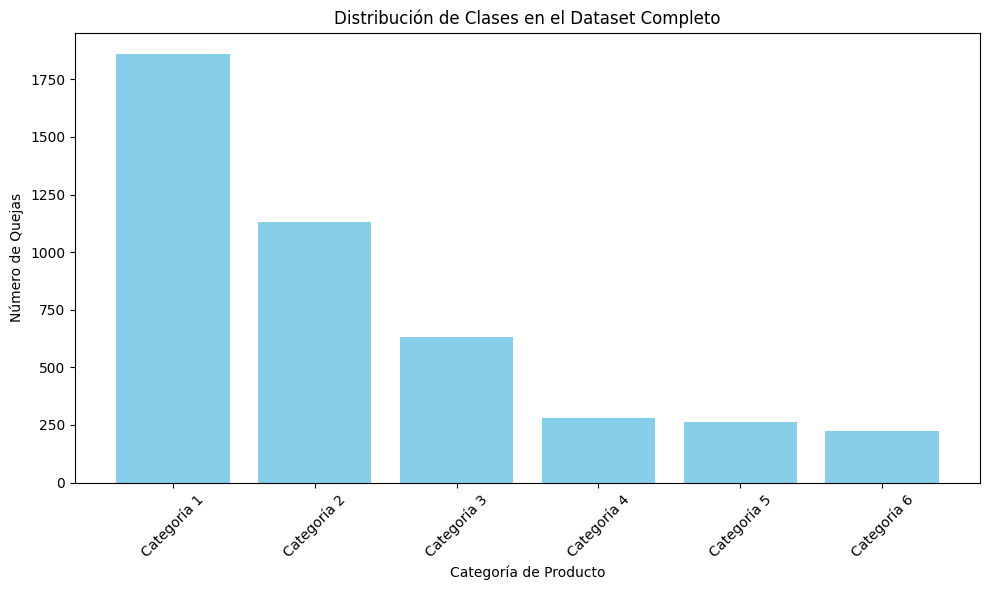

  Categoría Simplificada                                     Texto Original
0            Categoría 1  Credit reporting, credit repair services, or o...
1            Categoría 2  Credit reporting or other personal consumer re...
2            Categoría 3                                    Debt collection
3            Categoría 4                                           Mortgage
4            Categoría 5                        Credit card or prepaid card
5            Categoría 6                        Checking or savings account


In [11]:
import matplotlib.pyplot as plt
import pandas as pd


# Crear etiquetas simplificadas
etiquetas_simplificadas = [f"Categoría {i+1}" for i in range(len(total_por_categoria))]

# Crear la tabla de correspondencia
tabla_correspondencia = pd.DataFrame({
    "Categoría Simplificada": etiquetas_simplificadas,
    "Texto Original": total_por_categoria.index  # Guardamos los nombres largos originales aquí
})

# Crear el gráfico de barras con etiquetas simplificadas
plt.figure(figsize=(10, 6))
plt.bar(etiquetas_simplificadas, total_por_categoria.values, color='skyblue')
plt.title("Distribución de Clases en el Dataset Completo")
plt.xlabel("Categoría de Producto")
plt.ylabel("Número de Quejas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar la tabla de correspondencia debajo del gráfico
print(tabla_correspondencia)



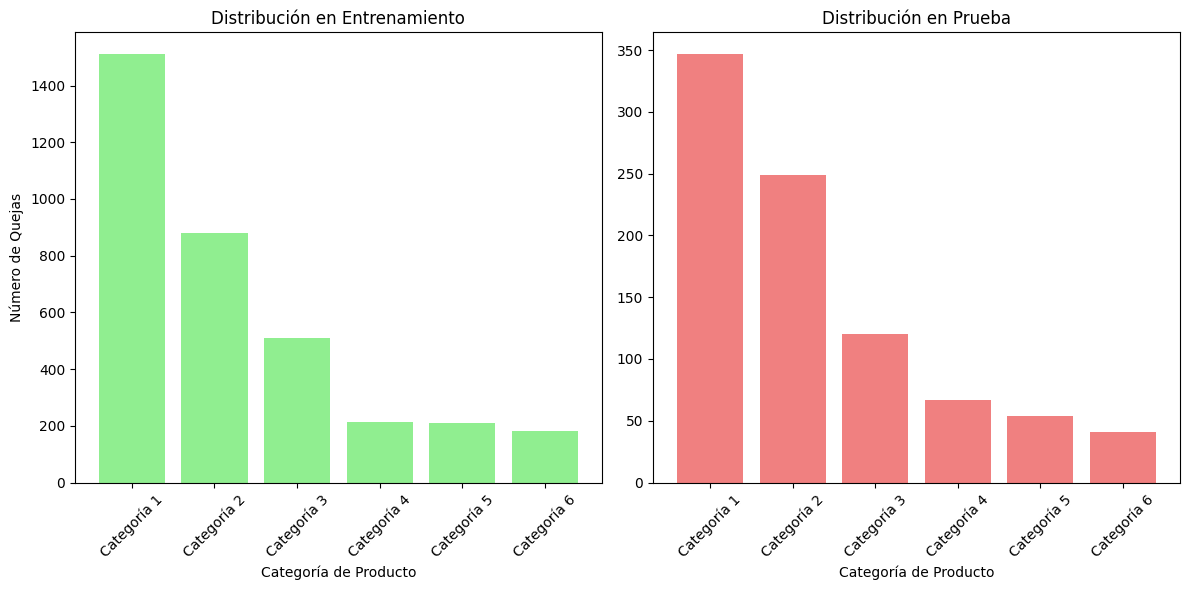

Tabla de correspondencia para Entrenamiento:
  Categoría Simplificada                                     Texto Original
0            Categoría 1  Credit reporting, credit repair services, or o...
1            Categoría 2  Credit reporting or other personal consumer re...
2            Categoría 3                                    Debt collection
3            Categoría 4                                           Mortgage
4            Categoría 5                        Credit card or prepaid card
5            Categoría 6                        Checking or savings account

Tabla de correspondencia para Prueba:
  Categoría Simplificada                                     Texto Original
0            Categoría 1  Credit reporting, credit repair services, or o...
1            Categoría 2  Credit reporting or other personal consumer re...
2            Categoría 3                                    Debt collection
3            Categoría 4                                           Mortgage
4   

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


# Crear etiquetas simplificadas para cada gráfico
etiquetas_simplificadas_entrenamiento = [f"Categoría {i+1}" for i in range(len(entrenamiento_por_categoria))]
etiquetas_simplificadas_prueba = [f"Categoría {i+1}" for i in range(len(prueba_por_categoria))]

# Crear tablas de correspondencia para ambos conjuntos
tabla_correspondencia_entrenamiento = pd.DataFrame({
    "Categoría Simplificada": etiquetas_simplificadas_entrenamiento,
    "Texto Original": entrenamiento_por_categoria.index  # Usamos el índice original aquí
})

tabla_correspondencia_prueba = pd.DataFrame({
    "Categoría Simplificada": etiquetas_simplificadas_prueba,
    "Texto Original": prueba_por_categoria.index  # Usamos el índice original aquí
})

# Crear gráficos de barras con etiquetas simplificadas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para el conjunto de entrenamiento
ax[0].bar(etiquetas_simplificadas_entrenamiento, entrenamiento_por_categoria.values, color='lightgreen')
ax[0].set_title("Distribución en Entrenamiento")
ax[0].set_xlabel("Categoría de Producto")
ax[0].set_ylabel("Número de Quejas")
ax[0].tick_params(axis='x', rotation=45)

# Gráfico para el conjunto de prueba
ax[1].bar(etiquetas_simplificadas_prueba, prueba_por_categoria.values, color='lightcoral')
ax[1].set_title("Distribución en Prueba")
ax[1].set_xlabel("Categoría de Producto")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar tablas de correspondencia para ambos conjuntos
print("Tabla de correspondencia para Entrenamiento:")
print(tabla_correspondencia_entrenamiento)
print("\nTabla de correspondencia para Prueba:")
print(tabla_correspondencia_prueba)



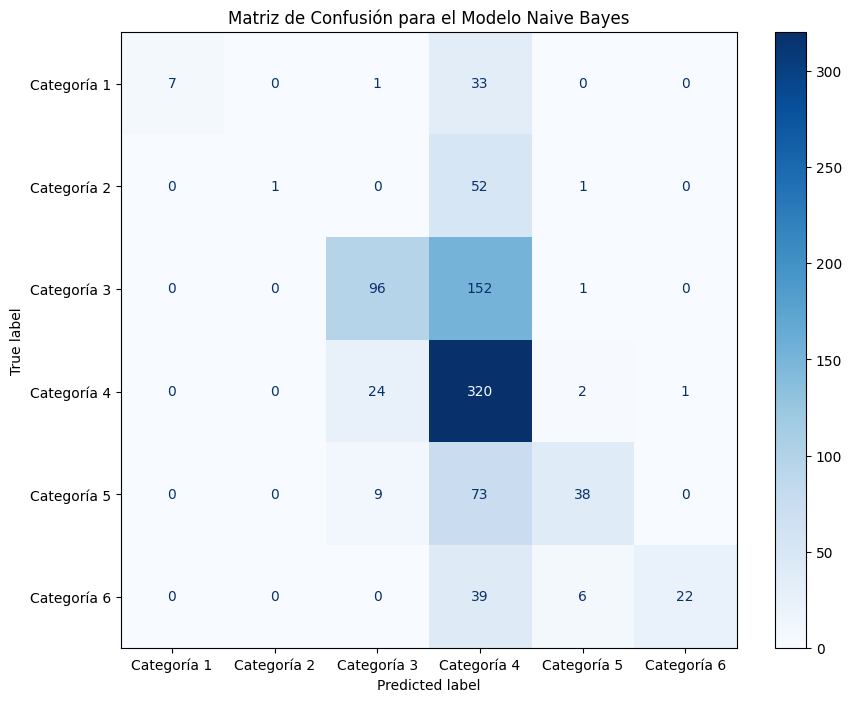

Tabla de correspondencia de etiquetas:
  Categoría Simplificada                                  Etiqueta Original
0            Categoría 1                        Checking or savings account
1            Categoría 2                        Credit card or prepaid card
2            Categoría 3  Credit reporting or other personal consumer re...
3            Categoría 4  Credit reporting, credit repair services, or o...
4            Categoría 5                                    Debt collection
5            Categoría 6                                           Mortgage


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Crear etiquetas simplificadas
etiquetas_simplificadas = [f"Categoría {i+1}" for i in range(len(nb_model.classes_))]

# Crear tabla de correspondencia para etiquetas originales y simplificadas
tabla_correspondencia = pd.DataFrame({
    "Categoría Simplificada": etiquetas_simplificadas,
    "Etiqueta Original": nb_model.classes_
})

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas_simplificadas)

# Visualizar la matriz de confusión con etiquetas simplificadas
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap="Blues", ax=ax)
plt.title("Matriz de Confusión para el Modelo Naive Bayes")
plt.show()

# Mostrar la tabla de correspondencia
print("Tabla de correspondencia de etiquetas:")
print(tabla_correspondencia)


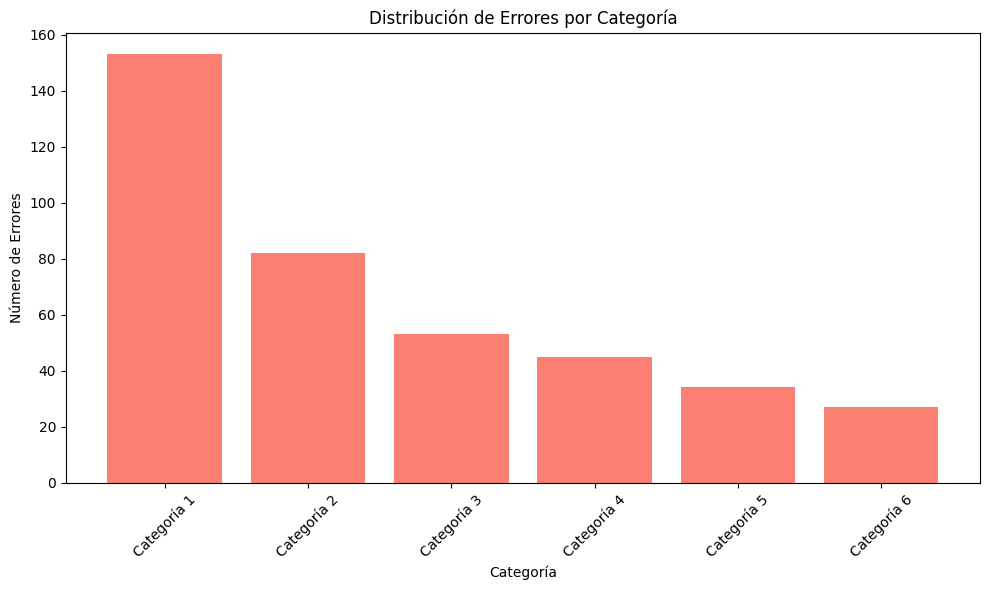

Tabla de correspondencia de errores por categoría:
  Categoría Simplificada                                  Etiqueta Original
0            Categoría 1  Credit reporting or other personal consumer re...
1            Categoría 2                                    Debt collection
2            Categoría 3                        Credit card or prepaid card
3            Categoría 4                                           Mortgage
4            Categoría 5                        Checking or savings account
5            Categoría 6  Credit reporting, credit repair services, or o...


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear una serie de errores por categoría
errores_por_categoria = y_test[y_test != y_pred].value_counts()

# Crear etiquetas simplificadas para las categorías con errores
etiquetas_simplificadas = [f"Categoría {i+1}" for i in range(len(errores_por_categoria))]
tabla_correspondencia = pd.DataFrame({
    "Categoría Simplificada": etiquetas_simplificadas,
    "Etiqueta Original": errores_por_categoria.index  # Guardamos los nombres largos originales aquí
})

# Visualizar errores por categoría con etiquetas simplificadas
plt.figure(figsize=(10, 6))
plt.bar(etiquetas_simplificadas, errores_por_categoria.values, color='salmon')
plt.title("Distribución de Errores por Categoría")
plt.xlabel("Categoría")
plt.ylabel("Número de Errores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar la tabla de correspondencia debajo del gráfico
print("Tabla de correspondencia de errores por categoría:")
print(tabla_correspondencia)


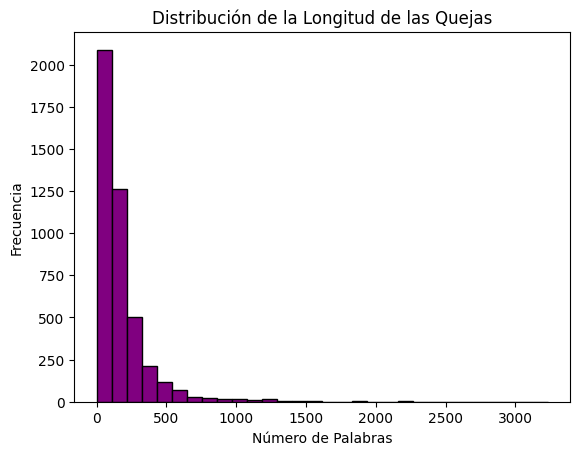

In [15]:
df_filtered_1['text_length'] = df_filtered_1['Consumer complaint narrative'].apply(lambda x: len(x.split()))

# Histograma de la longitud de textos
plt.hist(df_filtered_1['text_length'], bins=30, color='purple', edgecolor='black')
plt.title("Distribución de la Longitud de las Quejas")
plt.xlabel("Número de Palabras")
plt.ylabel("Frecuencia")
plt.show()
